In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('FinalWNVData v.1')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
 11  Tmax                    10506 non-null  float64
 12  Tmin                    10506 non-null  float64
 13  Tavg                    10506 non-null  float64
 14  Depart                  10506 non-null

# Weight of Evidence/Information Value

In [30]:
#First let's split our data into training and testing sets.
X = df.drop(columns=['WnvPresent'])
y = df['WnvPresent']

#Next, let's sample an equal proportion of both positive and negative cases so our model can fairly learn between the two cases.
negative = y[y.eq(0)==True]
positive = y[y.eq(1)==True]
neg_sample = negative.sample(n=551,random_state = 42)
X2_neg = X.iloc[neg_sample.index]
X2_pos = X.iloc[positive.index]
X2 = X2_neg.append(X2_pos)
y2 = neg_sample.append(positive)

#Now finally let's do the train/test split.
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size = 0.3,random_state = 42)

In [31]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
            
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [32]:
final_iv, IV = data_vars(X_train,y_train)

Date
Address
Block
0   -0.024052
1    0.024896
dtype: float64
Street
Trap
AddressNumberAndStreet
Latitude
0   -0.080298
1    0.081987
dtype: float64


C:\Users\Smartjuice\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Longitude
0     0.771374
1          NaN
2     0.068658
3     0.485173
4     0.309820
5     0.340592
6    -0.204636
7    -0.427779
8    -0.364978
9    -0.427779
10    0.235231
11   -0.204636
12   -0.875804
13   -0.155845
14    0.068658
15   -0.288017
16   -0.020422
17   -0.470339
dtype: float64
AddressAccuracy
0   -0.027133
1    0.044078
dtype: float64
NumMosquitos
0   -1.357642
1    0.340592
2    0.972181
dtype: float64
Tmax
0    -1.568951
1    -0.255929
2     0.158270
3     1.510663
4     1.187889
5     0.158270
6     0.083546
7    -0.996432
8    -0.790811
9     0.578677
10         NaN
11    0.314616
12   -1.243529
13    0.550312
14   -0.575699
15    0.697266
dtype: float64
Tmin
0   -0.284583
1    0.298873
dtype: float64
Tavg
0   -0.009163
1    0.009629
dtype: float64
Depart
0   -0.172948
1    0.177138
dtype: float64
DewPoint
0   -0.228199
1    0.029058
2    0.241062
dtype: float64
WetBulb
0   -0.092653
1   -0.005154
2    0.131100
dtype: float64
Heat
0    0.099613
1   -1.628849
dtype:

In [33]:
IV.sort_values(by='IV',ascending=False)

,VAR_NAME,IV
48,Sunset,1.337705
16,Date,1.104398
47,Sunrise,1.025106
35,NumMosquitos,0.876322
26,June,0.790813
...,...,...
30,Leyden Township,0.000044
21,HZ,0.000002
52,Thornton Township,0.000000
11,CULEX TARSALIS,0.000000


In [34]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(771, 35)

,Address,AddressNumberAndStreet,August,AvgSpeed,BR,CULEX PIPIENS,CULEX RESTUANS,CodeSum,DZ,Depart,...,TimeSinceLastDZ,TimeSinceLastFG,TimeSinceLastHZ,TimeSinceLastTS,TimeSinceLastTSRA,TimeSinceLastVCTS,Tmax,Tmin,Trap,VCTS
9247,"6100 West Fullerton Avenue, Chicago, IL 60639,...","6100 W FULLERTON AVE, Chicago, IL",1,7.45,0,1,1,,0,-2.0,...,21.942014,67.63491,35.0,13.0,24.0,26.365388,81.5,61.0,T013,0
5047,"ORD Terminal 5, O'Hare International Airport, ...","1000 W OHARE AIRPORT, Chicago, IL",0,9.85,0,0,1,RA,0,0.0,...,21.942014,67.63491,17.0,38.0,3.0,26.365388,84.0,65.0,T900,0
251,"7000 North Moselle Avenue, Chicago, IL 60646, USA","7000 N MOSELL AVE, Chicago, IL",0,8.30,0,0,1,,0,-6.0,...,34.000000,34.00000,6.0,34.0,6.0,6.000000,78.0,55.5,T008,0
510,"3300 West Randolph Street, Chicago, IL 60612, USA","3300 E RANDOLPH ST, Chicago, IL",0,10.35,1,1,1,TSRA RA BR VCTS,0,3.0,...,50.000000,50.00000,0.0,0.0,0.0,0.000000,85.0,69.0,T044,1
10209,"6100 West Fullerton Avenue, Chicago, IL 60639,...","6100 W FULLERTON AVE, Chicago, IL",0,9.60,0,1,1,RA,0,7.0,...,21.942014,14.00000,14.0,55.0,66.0,26.365388,82.5,62.5,T013,0


In [35]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Longitude with VIF of 162630.971033
Iteration # 2
Removing StnPressure with VIF of 3070.696253
Iteration # 3
Removing DewPoint with VIF of 935.518853
Iteration # 4
Removing Tmin with VIF of 430.393704
Iteration # 5
Removing Tmax with VIF of 78.944030
Iteration # 6
Removing AvgSpeed with VIF of 69.599121
Iteration # 7
Removing TimeSinceLastFG with VIF of 21.174660
Iteration # 8
Removing TimeSinceLastVCTS with VIF of 14.767350
Iteration # 9
Removing TimeSinceLastTS with VIF of 10.840727
Iteration # 10
Removing TimeSinceLastDZ with VIF of 8.852541
Iteration # 11
Removing ResultSpeed with VIF of 6.548550
Iteration # 12
Removing CULEX PIPIENS with VIF of 5.489233
Iteration # 13
Complete


In [36]:
final_vif

,VIFactor,features
3,1.116346,DZ
12,1.289412,October
17,1.356009,VCTS
11,1.582770,Monday
8,1.694303,Jefferson Township
10,1.806354,June
7,1.813637,Heat
5,1.813967,FG
13,1.915458,TS
9,2.113299,July


In [37]:
final_df

,August,BR,CULEX RESTUANS,DZ,Depart,FG,Friday,Heat,Jefferson Township,July,June,Monday,October,TS,Thursday,TimeSinceLastHZ,TimeSinceLastTSRA,VCTS
9247,1,0,1,0,-2.0,0,0,0.0,1,0,0,0,0,0,1,35.0,24.0,0
5047,0,0,1,0,0.0,0,0,0.0,1,1,0,1,0,0,0,17.0,3.0,0
251,0,0,1,0,-6.0,0,0,0.0,1,1,0,1,0,0,0,6.0,6.0,0
510,0,1,1,0,3.0,0,0,0.0,0,1,0,0,0,1,0,0.0,0.0,1
10209,0,0,1,0,7.0,0,0,0.0,1,0,0,0,0,0,1,14.0,66.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10024,0,0,1,0,5.0,0,1,0.0,0,0,0,0,0,0,0,8.0,60.0,0
29,0,1,1,0,-9.0,0,0,8.5,0,0,1,0,0,0,0,7.0,7.0,0
10099,0,0,0,0,5.0,0,1,0.0,0,0,0,0,0,0,0,8.0,60.0,0
10386,0,1,1,0,14.0,1,0,0.0,1,0,0,0,0,1,1,0.0,0.0,0


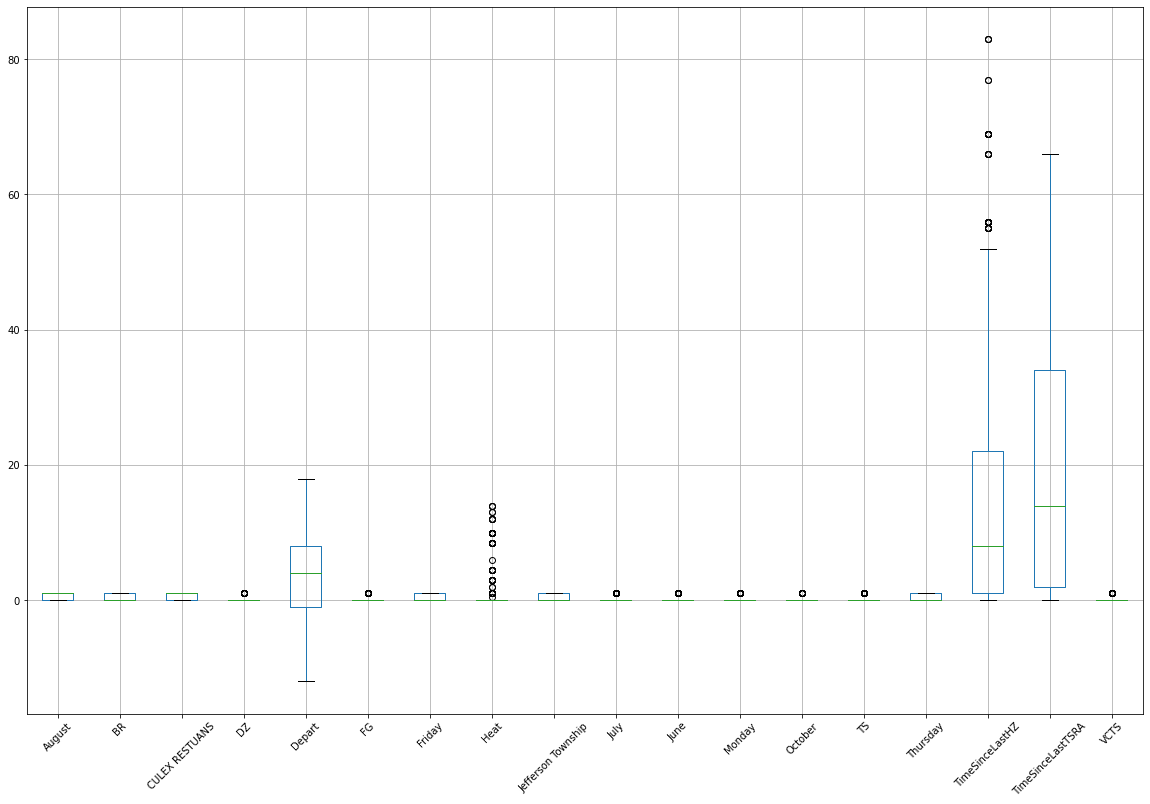

In [38]:
plt.figure(figsize=(20,13))
final_df.boxplot()
plt.xticks(rotation=45);

In [39]:
quantile = final_df['TimeSinceLastHZ'].quantile(.95)
trimmed_df = final_df[final_df['TimeSinceLastHZ']<quantile]
#quantile = final_df['TimeSinceLastTSRA'].quantile(.95)
#trimmed_df = trimmed_df[trimmed_df['TimeSinceLastTSRA']<quantile]
for index in set(y_train.index).difference(set(trimmed_df.index)):
    y_train.drop(index,inplace=True)

In [40]:
#Let's save this final dataframe now as our training data
trimmed_df.to_csv('X_train',index=False)
y_train.to_csv('y_train',index=False)
X_test.to_csv('X_test',index=False)
y_test.to_csv('y_test',index=False)